In [1]:
from sklearn.linear_model import RANSACRegressor, LinearRegression
import numpy as np
import matplotlib.pyplot as plt
import os
from datetime import datetime
import pandas as pd
from QCM import *
import random
from sklearn.linear_model import LinearRegression
from sklearn.utils import resample
import ruptures as rpt

path = '/Users/braden/Documents/ProbeTools/Testbed'
os.chdir(path)
print(os.getcwd())

/Users/braden/Documents/ProbeTools/Testbed


QCM_26-68deg_0V_300V_suppression_bias.txt
Auto threshold: 3.080477397635038e-05
Deposition rate (slope): 3.03e-07


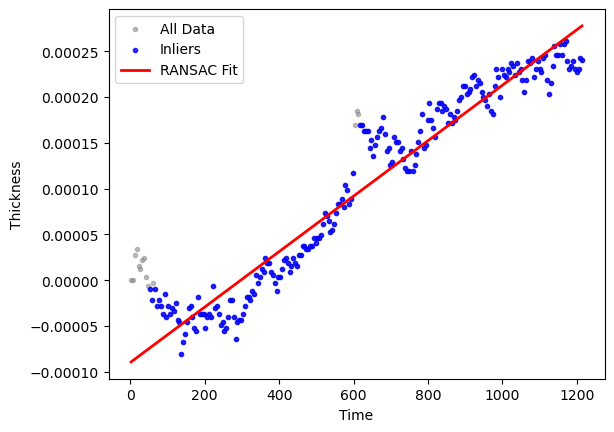

QCM_26-68deg_0V_no_suppression_bias.txt
Auto threshold: 2.786345308191527e-05
Deposition rate (slope): 1e-07


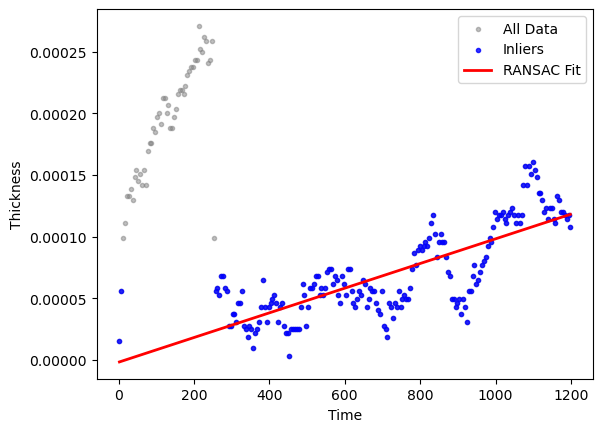

QCM_26-68deg_100V_300V_suppression_bias.txt
Auto threshold: 1.776998698042429e-05
Deposition rate (slope): 2.28e-07


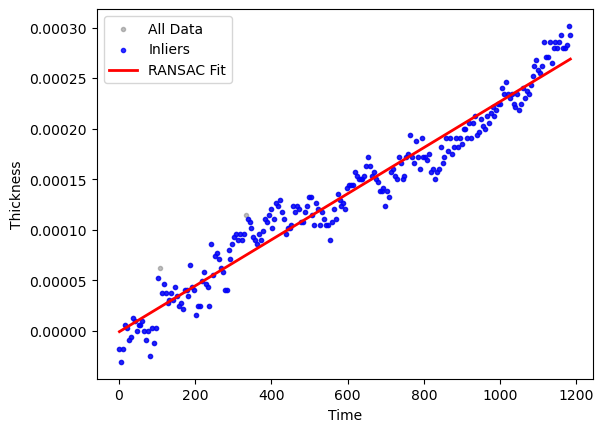

QCM_26-68deg_150V_300V_suppression_bias.txt
Auto threshold: 3.519795926063462e-05
Deposition rate (slope): 3.26e-07


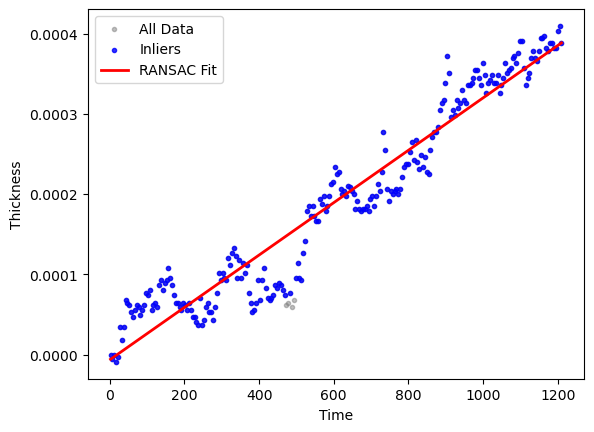

QCM_26-68deg_34V_300V_suppression_bias.txt
Auto threshold: 1.5998643178091097e-05
Deposition rate (slope): 3.37e-07


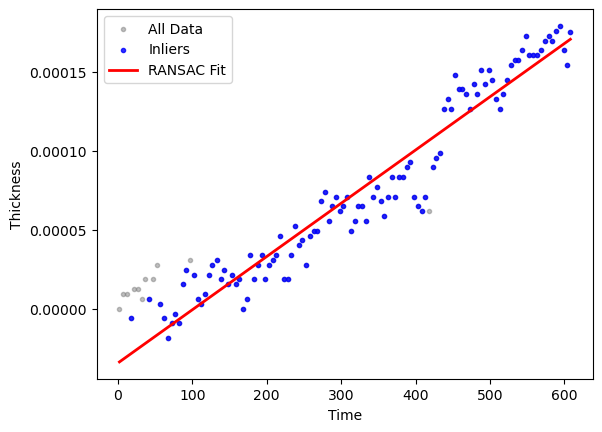

QCM_26-68deg_34V_no_suppression_bias.txt
Auto threshold: 1.5881972508347875e-05
Deposition rate (slope): 9.69e-08


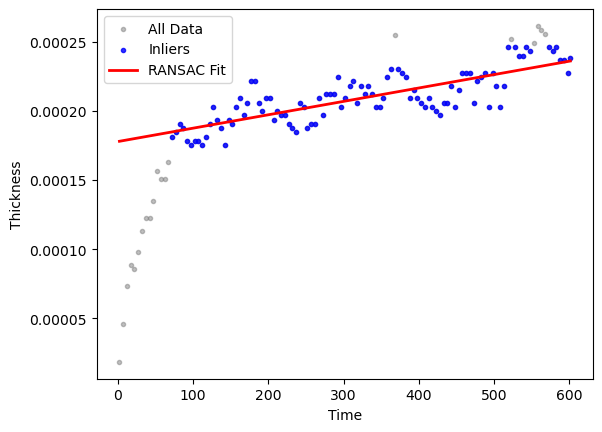

[3.0344236930320803e-07,
 1.0032731182955723e-07,
 2.280433841325814e-07,
 3.2657697856491634e-07,
 3.370344189901569e-07,
 9.739377391569234e-08]

In [9]:
def RANSAC(times, thics, plot=False, scalefactor=2.5):
    # times and thickness should be numpy arrays
    X = times.reshape(-1, 1)
    y = thics

    # 1. Fit with automatic inliner thresholding
    model = RANSACRegressor(LinearRegression())
    model.fit(X, y)
    # 2. Compute the automatic threshold value
    y_pred = model.estimator_.predict(X)
    residuals = np.abs(y - y_pred)
    mad = np.median(residuals)
    auto_threshold = 1.4826 * mad
    print("Auto threshold:", auto_threshold)
    # 3. Re-fit the model with the scaled-up threshold
    scaled_threshold = auto_threshold * scalefactor
    model = RANSACRegressor(LinearRegression(), residual_threshold=scaled_threshold, random_state=0)
    model.fit(X, y)
    # 4. Extract the metrics I care about
    slope = model.estimator_.coef_[0]
    intercept = model.estimator_.intercept_
    inlier_mask = model.inlier_mask_ # True for points considered inliers

    print(f"Deposition rate (slope): {slope:.3g}")

    # Plot all data
    if plot:
        plt.figure()
        plt.scatter(X, y, color='gray', label="All Data", marker='.', alpha=0.5)
        # Optionally highlight inliers
        plt.scatter(X[model.inlier_mask_], y[model.inlier_mask_], marker='.', color='blue', label="Inliers", alpha=0.8)

        # For a nice line, make a range of X:
        X_line = np.linspace(X.min(), X.max(), 100).reshape(-1, 1)
        y_line = model.predict(X_line)
        plt.plot(X_line, y_line, color='red', lw=2, label="RANSAC Fit")

        plt.xlabel("Time")
        plt.ylabel("Thickness")
        plt.legend()
        plt.show()

    # Now let's bootstrap over RANSAC's inliers
    n_bootstraps = 500
    slopes, intercepts = [], []
    X_inliers, y_inliers = X[inlier_mask], y[inlier_mask]

    for _ in range(n_bootstraps):
        X_bs, y_bs = resample(X_inliers, y_inliers)
        model_bs = LinearRegression().fit(X_bs, y_bs)
        slopes.append(model_bs.coef_[0])
        intercepts.append(model_bs.intercept_)

    return np.mean(slopes), np.std(slopes)


# Obtain a list of all .txt file names 
files = os.listdir(path)
files = [f for f in files if f.endswith('.txt') and 'QCM' in f]
files.sort()

ransac_slopes = []
ransac_stds = []
for file in files:
    print(file)
    times, freqs, thics = load_QCM(file)
    slope, std = RANSAC(times, thics, True)
    ransac_slopes.append(slope)
    ransac_stds.append(std)

ransac_slopes

In [10]:
def randomized_sliding_window(times, thics, n=1000):
    length = len(times)

    counter = 0
    slopes = []
    intercepts = []
    while counter < n:
        width = random.randint(2, length//4)
        center = random.randint(2, length//6)

        start = center-width
        end = center + width
        if end < length and start >= 0:
            # Perform a line fit (first degree polynomial fit)
            coefficients = np.polyfit(times[start:end], thics[start:end], 1)
            slope = coefficients[0]     # [kAng/sec]
            intercept = coefficients[1]     # [kAng]
            slopes.append(slope)
            intercepts.append(intercept)
            counter += 1

    avg_slope = np.mean(slopes)
    std_slopes = np.std(slopes)

    return avg_slope, std_slopes


window_slopes = []
window_stds = []
for file in files:
    print(file)
    times, freqs, thics = load_QCM(file, bins=5)
    slope, std = randomized_sliding_window(times, thics)
    window_slopes.append(slope)
    window_stds.append(std)

window_slopes


QCM_26-68deg_0V_300V_suppression_bias.txt
QCM_26-68deg_0V_no_suppression_bias.txt
QCM_26-68deg_100V_300V_suppression_bias.txt
QCM_26-68deg_150V_300V_suppression_bias.txt
QCM_26-68deg_34V_300V_suppression_bias.txt
QCM_26-68deg_34V_no_suppression_bias.txt


[-1.8292524912212204e-07,
 4.145977325177907e-07,
 2.6373035187753635e-07,
 1.2784817061642934e-07,
 1.1344697600984063e-07,
 1.0518726820993837e-06]

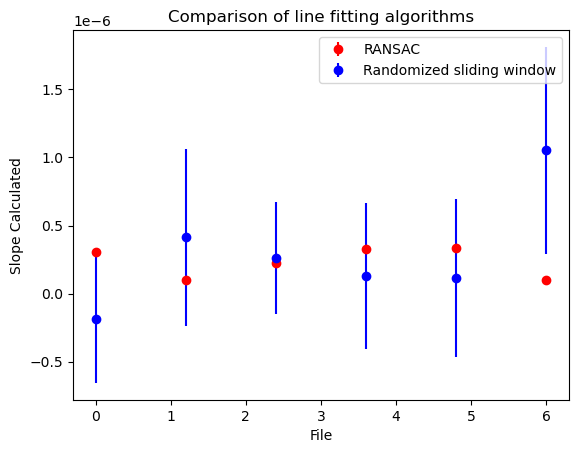

In [13]:
xs = np.linspace(0,6,6)
plt.errorbar(xs, ransac_slopes, yerr=ransac_stds, fmt='o', label='RANSAC', c='r')

plt.errorbar(xs, window_slopes, yerr=window_stds, fmt='o', label='Randomized sliding window', c='b')

plt.xlabel('File')
plt.ylabel('Slope Calculated')
plt.title('Comparison of line fitting algorithms')
plt.legend()

In [14]:
import numpy as np
import pymc as pm
import arviz as az
import matplotlib.pyplot as plt

def bayesian_linreg_mcmc(times, thics):
    times_mean = times.mean()
    times_centered = times - times_mean

    with pm.Model() as model:
        # Priors
        intercept = pm.Normal('intercept', mu=0, sigma=1e-4)
        slope = pm.Normal('slope', mu=1e-7, sigma=1e-6)  # Informed prior, positive/slight slope
        sigma = pm.HalfNormal('sigma', sigma=1e-4)
        nu = pm.Exponential('nu', 1/30)
        
        # Linear model
        mu = intercept + slope * times_centered
        
        # Outlier-robust likelihood
        y_obs = pm.StudentT('y_obs', mu=mu, sigma=sigma, nu=nu, observed=thics)
        
        # MCMC
        trace = pm.sample(3000, tune=1000, target_accept=0.95, random_seed=42, 
                          nuts_sampler_kwargs={"max_treedepth": 15}, return_inferencedata=True)
        
        slope_samples = trace.posterior['slope'].values.flatten()
        slope_mean = slope_samples.mean()
        slope_std = slope_samples.std()
        # 95% credible interval
        ci_95 = np.percentile(slope_samples, [2.5, 97.5])
        print(f"Mean slope: {slope_mean:.3e} ± {slope_std:.1e}")

    return slope_mean, ci_95

bayes_slopes = []
bayes_stds = []
bayes_cis = []
for file in files:
    print(file)
    times, freqs, thics = load_QCM(file, bins=5)
    slope, std, ci_95 = bayesian_linreg_mcmc(times, thics)
    bayes_slopes.append(slope)
    bayes_stds.append(std)
    bayes_cis.append(ci_95)

bayes_cis = np.array(bayes_cis)
bayes_slopes

QCM_26-68deg_0V_300V_suppression_bias.txt


Auto-assigning NUTS sampler...
Initializing NUTS using jitter+adapt_diag...
Multiprocess sampling (4 chains in 4 jobs)
NUTS: [intercept, slope, sigma, nu]


Output()

Sampling 4 chains for 1_000 tune and 3_000 draw iterations (4_000 + 12_000 draws total) took 115 seconds.


Mean slope: 2.889e-07 ± 7.2e-09
QCM_26-68deg_0V_no_suppression_bias.txt


Auto-assigning NUTS sampler...
Initializing NUTS using jitter+adapt_diag...
Multiprocess sampling (4 chains in 4 jobs)
NUTS: [intercept, slope, sigma, nu]


Output()

Sampling 4 chains for 1_000 tune and 3_000 draw iterations (4_000 + 12_000 draws total) took 67 seconds.


Mean slope: -3.853e-08 ± 1.2e-08
QCM_26-68deg_100V_300V_suppression_bias.txt


Auto-assigning NUTS sampler...
Initializing NUTS using jitter+adapt_diag...
Multiprocess sampling (4 chains in 4 jobs)
NUTS: [intercept, slope, sigma, nu]


Output()

Sampling 4 chains for 1_000 tune and 3_000 draw iterations (4_000 + 12_000 draws total) took 167 seconds.
Chain 0 reached the maximum tree depth. Increase `max_treedepth`, increase `target_accept` or reparameterize.
Chain 1 reached the maximum tree depth. Increase `max_treedepth`, increase `target_accept` or reparameterize.
Chain 2 reached the maximum tree depth. Increase `max_treedepth`, increase `target_accept` or reparameterize.
Chain 3 reached the maximum tree depth. Increase `max_treedepth`, increase `target_accept` or reparameterize.


Mean slope: 2.270e-07 ± 3.2e-09
QCM_26-68deg_150V_300V_suppression_bias.txt


Auto-assigning NUTS sampler...
Initializing NUTS using jitter+adapt_diag...
Multiprocess sampling (4 chains in 4 jobs)
NUTS: [intercept, slope, sigma, nu]


Output()

Sampling 4 chains for 1_000 tune and 3_000 draw iterations (4_000 + 12_000 draws total) took 106 seconds.


Mean slope: 3.278e-07 ± 6.1e-09
QCM_26-68deg_34V_300V_suppression_bias.txt


Auto-assigning NUTS sampler...
Initializing NUTS using jitter+adapt_diag...
Multiprocess sampling (4 chains in 4 jobs)
NUTS: [intercept, slope, sigma, nu]


Output()

Sampling 4 chains for 1_000 tune and 3_000 draw iterations (4_000 + 12_000 draws total) took 76 seconds.


Mean slope: 3.100e-07 ± 9.1e-09
QCM_26-68deg_34V_no_suppression_bias.txt


Auto-assigning NUTS sampler...
Initializing NUTS using jitter+adapt_diag...
Multiprocess sampling (4 chains in 4 jobs)
NUTS: [intercept, slope, sigma, nu]


Output()

Sampling 4 chains for 1_000 tune and 3_000 draw iterations (4_000 + 12_000 draws total) took 71 seconds.


Mean slope: 1.266e-07 ± 9.4e-09


[2.889366970311668e-07,
 -3.853176029127566e-08,
 2.2700625936461248e-07,
 3.27798022551975e-07,
 3.100329316237652e-07,
 1.2657307724599186e-07]

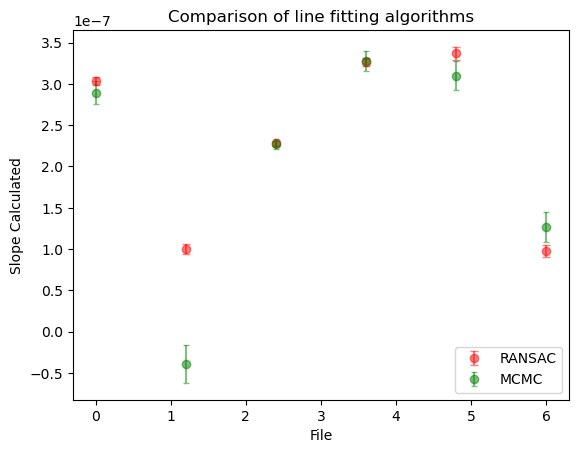

In [28]:
xs = np.linspace(0,6,6)
plt.errorbar(xs, ransac_slopes, yerr=ransac_stds, alpha=0.5,
             fmt='o', label='RANSAC', c='r', capsize=3)
#plt.errorbar(xs, window_slopes, yerr=window_stds, fmt='o', label='Randomized sliding window', 
#             alpha=0.5, capsize=4, c='b')

#plt.errorbar(xs, bayes_slopes, yerr=bayes_stds, fmt='o', label='Bayes', c='g')
plt.errorbar(xs, bayes_slopes, yerr=[bayes_slopes-bayes_cis[:,0], bayes_cis[:,1]-bayes_slopes], 
             fmt='o', alpha=0.5, capsize=2, c='g', label='MCMC')

plt.xlabel('File')
plt.ylabel('Slope Calculated')
plt.title('Comparison of line fitting algorithms')
plt.legend()

In [19]:
bayes_cis = np.array(bayes_cis)
bayes_cis[:,0]

array([ 2.75312336e-07, -6.19661788e-08,  2.20702666e-07,  3.15840857e-07,
        2.92040235e-07,  1.08187967e-07])

---
## Experimentation with Ruptures

In [ ]:
import ruptures as rpt


breakpoints_df = pd.DataFrame(columns=['Filename', 'Breakpoints', 'Start', 'End', 'Length'])

for file in files:

    times, freqs, thics = load_QCM(file, bins=5)

    plt.figure()
    plt.scatter(times, thics, alpha=0.4, label='All Data')
    plt.show()

    n_bkps = input('Number of discontinuities: ')
    try: n_bkps = int(n_bkps)
    except: n_bkps = 0

    # signal is your data, times and thicknesses are 1D numpy arrays
    signal = np.array(thics)

    algo = rpt.Binseg(model='rbf').fit(signal)
    bkps = algo.predict(n_bkps)  # Indices after changepoints, ending with len(signal)

    # Make segment boundaries: include zero at start
    boundaries = [0] + bkps  # e.g. [0, 150, 340, 600]
    segment_lengths = [boundaries[i+1] - boundaries[i] for i in range(len(boundaries)-1)]
    largest_idx = np.argmax(segment_lengths)
    start, end = boundaries[largest_idx], boundaries[largest_idx+1]
    print(boundaries)

    # Extract this biggest segment
    t_segment = times[start:end]
    th_segment = thics[start:end]

    breakpoints_df.loc[len(breakpoints_df)] = [file, n_bkps, start, end, len(thics)]

    plt.figure(figsize=(10,5))
    plt.scatter(times, thics, alpha=0.4, label='All Data')
    plt.scatter(t_segment, th_segment, color='orange', alpha=0.7, label='Largest segment')
    # Add regression line if you wish
    plt.legend()
    plt.title(file)
    plt.show()

breakpoints_df.to_csv('Breakpoints.csv', index=False)

In [2]:
def extract_metadata(file):
    parts = file.split('_')
    bias = int(parts[2][:-1])
    guard = '300V' in file
    split_angle = parts[1][:-3].split('-')
    if len(split_angle) == 1:
        angle = int(split_angle[0])
    elif len(split_angle) == 2:
        angle = int(split_angle[0]) + int(split_angle[1])/10**(len(split_angle[1]))
    else:
        Exception('Unexpected format for angle in file ' + file)
    return angle, bias, guard


breakpoints = obtain_breakpoints(os.getcwd(), targetfile='QCM Breakpoints.csv')    

QCM_df = pd.DataFrame(columns=['Filename', 'Slope', 'Lower ci', 'Upper ci', 'y_int', 'Rate', 'Lower Rate', 'Upper Rate'])

for i, row in breakpoints.iterrows():
    # Unpack file/breakpoint data from the row
    file = row['Filename']
    start = row['Start']
    end = row['End']
    print('Loading ' + file)
    # Extract metadata from the file header
    angle, bias, guard = extract_metadata(file)
    # Extract the data for Bayesian line fitting
    times, _, thics = load_QCM(file)
    times = times[start:end]
    thics = thics[start:end]
    # Perform the Bayesian line fit
    slope, y_int, ci_95 = bayesian_linreg_mcmc(times, thics)
    # Convert the rate and confidence band into um/kHr
    rate = slope * 60 * 60 * 1000 / 10    # Convert from [kAng/sec] -> [micron/kHr]
    lower = ci_95[0] * 60 * 60 * 1000 / 10
    upper = ci_95[1] * 60 * 60 * 1000 / 10

    QCM_df.loc[len(QCM_df)] = [file, slope, ci_95[0], ci_95[1], y_int, rate, lower, upper]

QCM_df.to_csv('QCM Database.csv', index=False)

Skipping QCM_26-68deg_0V_300V_suppression_bias.txt
Skipping QCM_26-68deg_0V_no_suppression_bias.txt
Skipping QCM_26-68deg_100V_300V_suppression_bias.txt
Skipping QCM_26-68deg_150V_300V_suppression_bias.txt
Skipping QCM_26-68deg_34V_300V_suppression_bias.txt
Skipping QCM_26-68deg_34V_no_suppression_bias.txt
No updates performed.
Loading QCM_26-68deg_0V_300V_suppression_bias.txt


Auto-assigning NUTS sampler...
Initializing NUTS using jitter+adapt_diag...
Multiprocess sampling (4 chains in 4 jobs)
NUTS: [intercept, slope, sigma, nu]


Output()

Sampling 4 chains for 1_000 tune and 3_000 draw iterations (4_000 + 12_000 draws total) took 106 seconds.


Mean slope: 2.889e-07 ± 7.2e-09
Loading QCM_26-68deg_0V_no_suppression_bias.txt


Auto-assigning NUTS sampler...
Initializing NUTS using jitter+adapt_diag...
Multiprocess sampling (4 chains in 4 jobs)
NUTS: [intercept, slope, sigma, nu]


Output()

Sampling 4 chains for 1_000 tune and 3_000 draw iterations (4_000 + 12_000 draws total) took 107 seconds.


Mean slope: 1.025e-07 ± 6.0e-09
Loading QCM_26-68deg_100V_300V_suppression_bias.txt


Auto-assigning NUTS sampler...
Initializing NUTS using jitter+adapt_diag...
Multiprocess sampling (4 chains in 4 jobs)
NUTS: [intercept, slope, sigma, nu]


Output()

Sampling 4 chains for 1_000 tune and 3_000 draw iterations (4_000 + 12_000 draws total) took 173 seconds.
Chain 0 reached the maximum tree depth. Increase `max_treedepth`, increase `target_accept` or reparameterize.
Chain 1 reached the maximum tree depth. Increase `max_treedepth`, increase `target_accept` or reparameterize.
Chain 2 reached the maximum tree depth. Increase `max_treedepth`, increase `target_accept` or reparameterize.
Chain 3 reached the maximum tree depth. Increase `max_treedepth`, increase `target_accept` or reparameterize.


Mean slope: 2.270e-07 ± 3.2e-09
Loading QCM_26-68deg_150V_300V_suppression_bias.txt


Auto-assigning NUTS sampler...
Initializing NUTS using jitter+adapt_diag...
Multiprocess sampling (4 chains in 4 jobs)
NUTS: [intercept, slope, sigma, nu]


Output()

Sampling 4 chains for 1_000 tune and 3_000 draw iterations (4_000 + 12_000 draws total) took 107 seconds.


Mean slope: 3.278e-07 ± 6.1e-09
Loading QCM_26-68deg_34V_300V_suppression_bias.txt


Auto-assigning NUTS sampler...
Initializing NUTS using jitter+adapt_diag...
Multiprocess sampling (4 chains in 4 jobs)
NUTS: [intercept, slope, sigma, nu]


Output()

Sampling 4 chains for 1_000 tune and 3_000 draw iterations (4_000 + 12_000 draws total) took 81 seconds.


Mean slope: 3.100e-07 ± 9.1e-09
Loading QCM_26-68deg_34V_no_suppression_bias.txt


Auto-assigning NUTS sampler...
Initializing NUTS using jitter+adapt_diag...
Multiprocess sampling (4 chains in 4 jobs)
NUTS: [intercept, slope, sigma, nu]


Output()

Sampling 4 chains for 1_000 tune and 3_000 draw iterations (4_000 + 12_000 draws total) took 73 seconds.


Mean slope: 1.266e-07 ± 9.4e-09


'QCM_26-68deg_0V_300V_suppression_bias.txt'

---
# Live Processing Run - Fixed Angle, variable bias

In [16]:
from QCM import *

dir_path = '/Users/braden/Documents/Beam Catcher/2025 Spring Test Campaign/2025-07 Processing Folder/Varied Bias at 27 deg'

QCM_df = QCM_construct_database(dir_path, bkp_file='QCM Breakpoints.csv', targetfile='QCM Database.csv')


26.68